In [23]:
from __future__ import print_function, division
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
import torch.nn.functional as F
from tqdm import tqdm, tqdm_notebook
from PIL import Image
import matplotlib.pyplot as plt
import time
import os

plt.ion()   # interactive mode
multiGPU = False

%matplotlib inline

In [24]:
TRAIN_IMG_PATH = "../input/train/train/"
TEST_IMG_PATH = "../input/test/test/"
LABELS_CSV_PATH = "../input/train.csv"
SAMPLE_SUB_PATH = "../input/sample_submission.csv"

## Preparing Dataset

In [25]:
class CactusDataset(Dataset):
    """Cactus identification dataset."""

    def __init__(self, img_dir, dataframe, transform=None):
        """
        Args:
            img_dir (string): Directory with all the images.        
            dataframe (pandas.core.frame.DataFrame): Pandas dataframe obtained
                by read_csv().
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.labels_frame = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.labels_frame.id[idx]) 
        image = Image.open(img_name)
        label = self.labels_frame.has_cactus[idx]

        if self.transform:
            image = self.transform(image)

        return [image, label] 


1
Shape of the image is:  (32, 32)


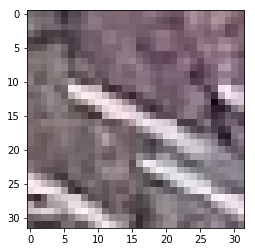

In [26]:
dframe = pd.read_csv(LABELS_CSV_PATH)
cut = int(len(dframe)*0.95)
train, test = np.split(dframe, [cut], axis=0)
test = test.reset_index(drop=True)

train_ds = CactusDataset(TRAIN_IMG_PATH, train)
test_ds = CactusDataset(TRAIN_IMG_PATH, test)
idx = 1
plt.imshow(train_ds[idx][0])
print(train_ds[idx][1])
print("Shape of the image is: ", train_ds[idx][0].size)


In [27]:
data_transform = transforms.Compose([
        transforms.RandomResizedCrop(32),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
    ])

In [28]:
train_ds = CactusDataset(TRAIN_IMG_PATH, train, data_transform)
test_ds = CactusDataset(TRAIN_IMG_PATH, test, data_transform)
datasets = {"train": train_ds, "val": test_ds}

idx = 29
print(train_ds[idx][1])
print("Shape of the image is: ", train_ds[idx][0].shape)

1
Shape of the image is:  torch.Size([3, 32, 32])


In [29]:
trainloader = DataLoader(train_ds, batch_size=32,
                        shuffle=True, num_workers=0)

testloader = DataLoader(test_ds, batch_size=4,
                        shuffle=True, num_workers=0)

dataloaders = {"train": trainloader, "val": testloader}

In [30]:
num_epochs = 25
num_classes = 2
batch_size = 128
learning_rate = 0.002
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Training

In [31]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in tqdm_notebook(range(num_epochs)):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:     
            since_epoch = time.time()
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode
    
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in tqdm_notebook(dataloaders[phase]):
                # get the inputs
                inputs, labels = data

                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(datasets[phase])
            epoch_acc = running_corrects.double() / len(datasets[phase])

            time_elapsed_epoch = time.time() - since_epoch
            print('{} Loss: {:.4f} Acc: {:.4f} in {:.0f}m {:.0f}s'.format(
                phase, epoch_loss, epoch_acc, time_elapsed_epoch // 60, time_elapsed_epoch % 60))
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    return model

In [52]:
class CactiCNN(nn.Module):
    def __init__(self):
        # ancestor constructor call
        super(CactiCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=2)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=2)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=2)
        self.conv6 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=2)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
        self.bn5 = nn.BatchNorm2d(512)
        self.bn6 = nn.BatchNorm2d(1024)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=1)
        self.avg = nn.AvgPool2d(4)
        self.fc = nn.Linear(1024 * 9 * 9, 2) # !!!
   
    def forward(self, x):
        x = self.pool(F.leaky_relu(self.bn1(self.conv1(x)))) # first convolutional layer then batchnorm, then activation then pooling layer.
        x = self.pool(F.leaky_relu(self.bn2(self.conv2(x))))
        x = self.pool(F.leaky_relu(self.bn3(self.conv3(x))))
        x = self.pool(F.leaky_relu(self.bn4(self.conv4(x))))
        x = self.pool(F.leaky_relu(self.bn5(self.conv5(x))))
        x = self.pool(F.relu(self.bn6(self.conv6(x))))
        x = self.avg(x)
        #print(x.shape) # lifehack to find out the correct dimension for the Linear Layer
        x = x.view(-1, 1024 * 9 * 9) # !!!
        x = self.fc(x)
        return x

In [53]:
model = CactiCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
model_ft = train_model(model, criterion, optimizer, exp_lr_scheduler,
                           num_epochs=num_epochs)

Epoch 0/24
----------


train Loss: 0.4310 Acc: 0.8795 in 2m 21s


val Loss: 0.8200 Acc: 0.5783 in 0m 3s

Epoch 1/24
----------


train Loss: 0.2107 Acc: 0.9146 in 2m 19s


val Loss: 0.2517 Acc: 0.8891 in 0m 3s

Epoch 2/24
----------


## Submission

In [ ]:
submission_df = pd.read_csv(SAMPLE_SUB_PATH)
output_df = pd.DataFrame(index=submission_df.index, columns=submission_df.keys() )
output_df['id'] = submission_df['id']
submission_df['target'] =  [0] * len(submission_df)

tdata_transform = transforms.Compose([
        transforms.CenterCrop(32),
        transforms.ToTensor(),
])

submission_ds = CactusDataset(TEST_IMG_PATH, submission_df, tdata_transform)

sub_loader = DataLoader(submission_ds, batch_size=1,
                        shuffle=False, num_workers=0)


def test_sumission(model):
    since = time.time()
    sub_outputs = []
    model.train(False)  # Set model to evaluate mode
    # Iterate over data.
    prediction = []
    for data in sub_loader:
        # get the inputs
        inputs, labels = data

        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward
        outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1)
        prediction.append(int(pred))
      
    time_elapsed = time.time() - since
    print('Run complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    return prediction

In [ ]:
sub = pd.read_csv('../input/sample_submission.csv')
sub['has_cactus'] = test_sumission(model_ft)
sub.to_csv('submission1.csv', index= False)

In [ ]:
sub.head()